In [15]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
face_cascade = cv2.CascadeClassifier('opencv\haarcascades\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('opencv\haarcascades\haarcascade_eye.xml')

In [17]:
def get_cropped_img_if_2_eyes(img_pth):
    img = cv2.imread(img_pth)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >=2:
            return roi_color
        else:
            return None

In [18]:
pathToData = r'dataset'
pathToCroppedData = r'dataset\cropped'

In [19]:
import os
img_dirs = []
for entry in os.scandir(pathToData):
    if entry.is_dir(): img_dirs.append(entry.path)
img_dirs

['dataset\\Akshay Kumar',
 'dataset\\Alexandra Daddario',
 'dataset\\Alia Bhatt',
 'dataset\\Amitabh Bachchan',
 'dataset\\Andy Samberg',
 'dataset\\Anushka Sharma',
 'dataset\\Billie Eilish',
 'dataset\\Brad Pitt',
 'dataset\\Camila Cabello',
 'dataset\\Charlize Theron',
 'dataset\\Claire Holt',
 'dataset\\Courtney Cox',
 'dataset\\Dwayne Johnson',
 'dataset\\Elizabeth Olsen',
 'dataset\\Ellen Degeneres',
 'dataset\\Henry Cavill',
 'dataset\\Hrithik Roshan',
 'dataset\\Hugh Jackman',
 'dataset\\Jessica Alba',
 'dataset\\Kashyap',
 'dataset\\lionel_messi',
 'dataset\\Lisa Kudrow',
 'dataset\\Margot Robbie',
 'dataset\\maria_sharapova',
 'dataset\\Marmik',
 'dataset\\Natalie Portman',
 'dataset\\Priyanka Chopra',
 'dataset\\Robert Downey Jr',
 'dataset\\Roger Federer',
 'dataset\\roger_federer',
 'dataset\\serena_williams',
 'dataset\\Tom Cruise',
 'dataset\\Vijay Deverakonda',
 'dataset\\Virat Kohli',
 'dataset\\virat_kohli',
 'dataset\\Zac Efron']

In [20]:
import shutil
if os.path.exists(pathToCroppedData):
    shutil.rmtree(pathToCroppedData)
os.mkdir(pathToCroppedData)

In [21]:
cropped_img_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 0
    celebrity_name = img_dir.split('\\')[-1]
    print(celebrity_name)

    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        roi_color = get_cropped_img_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = os.path.join(pathToCroppedData,celebrity_name)#pathToCroppedData + '\\' + celebrity_name
            if not os.path.exists(cropped_folder):
                cropped_img_dirs.append(cropped_folder)
                os.makedirs(cropped_folder)
            
            cropped_file_name = celebrity_name + str(count) + '.png'
            cropped_file_path = os.path.join(cropped_folder,cropped_file_name)#cropped_folder + "\\" + cropped_file_name

            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Akshay Kumar
Alexandra Daddario
Alia Bhatt
Amitabh Bachchan
Andy Samberg
Anushka Sharma
Billie Eilish
Brad Pitt
Camila Cabello
Charlize Theron
Claire Holt
Courtney Cox
Dwayne Johnson
Elizabeth Olsen
Ellen Degeneres
Henry Cavill
Hrithik Roshan
Hugh Jackman
Jessica Alba
Kashyap
lionel_messi
Lisa Kudrow
Margot Robbie
maria_sharapova
Marmik
Natalie Portman
Priyanka Chopra
Robert Downey Jr
Roger Federer
roger_federer
serena_williams
Tom Cruise
Vijay Deverakonda
Virat Kohli
virat_kohli
Zac Efron


In [22]:
import pywt
def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)
    return imArray_H

In [23]:

class_dict = dict()
for idx, celebrity_name in enumerate(celebrity_file_names_dict.keys(),-1):
    if celebrity_name != 'cropped':
        class_dict[celebrity_name]=idx
class_dict

{'Akshay Kumar': -1,
 'Alexandra Daddario': 0,
 'Alia Bhatt': 1,
 'Amitabh Bachchan': 2,
 'Andy Samberg': 3,
 'Anushka Sharma': 4,
 'Billie Eilish': 5,
 'Brad Pitt': 6,
 'Camila Cabello': 7,
 'Charlize Theron': 8,
 'Claire Holt': 9,
 'Courtney Cox': 10,
 'Dwayne Johnson': 11,
 'Elizabeth Olsen': 12,
 'Ellen Degeneres': 13,
 'Henry Cavill': 14,
 'Hrithik Roshan': 15,
 'Hugh Jackman': 16,
 'Jessica Alba': 17,
 'Kashyap': 18,
 'lionel_messi': 19,
 'Lisa Kudrow': 20,
 'Margot Robbie': 21,
 'maria_sharapova': 22,
 'Marmik': 23,
 'Natalie Portman': 24,
 'Priyanka Chopra': 25,
 'Robert Downey Jr': 26,
 'Roger Federer': 27,
 'roger_federer': 28,
 'serena_williams': 29,
 'Tom Cruise': 30,
 'Vijay Deverakonda': 31,
 'Virat Kohli': 32,
 'virat_kohli': 33,
 'Zac Efron': 34}

In [24]:
X=[]
Y=[]
for celebrity_name, training_file in celebrity_file_names_dict.items():
    for training_image in training_file:
        img = cv2.imread(training_image)
        if img is not None:
            scaled_raw_img = cv2.resize(img,(32,32))
            img_har = w2d(img,'db1',5)
            scaled_img_har = cv2.resize(img_har,(32,32))
            combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
            X.append(combined_img)
            Y.append(class_dict[celebrity_name])
# len(X)
# len(X[0])
X = np.array(X).reshape(len(X),len(X[0])).astype(float)
X.shape

(2172, 4096)

In [25]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=0)
pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])
pipe.fit(X_train,Y_train)
pipe.score(X_test,Y_test)

0.5432780847145487

In [27]:
len(X_test)
print(classification_report(Y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.33      0.07      0.11        15
           0       0.60      0.88      0.71        17
           1       0.30      0.35      0.32        17
           2       0.00      0.00      0.00         5
           3       0.56      0.64      0.60        22
           4       0.67      0.29      0.40        14
           5       0.57      0.36      0.44        11
           6       0.55      0.79      0.65        28
           7       0.62      0.53      0.57        15
           8       0.47      0.35      0.40        20
           9       0.39      0.60      0.47        20
          10       0.56      0.53      0.54        19
          11       0.43      0.38      0.40         8
          12       0.40      0.44      0.42         9
          13       0.56      0.64      0.60        22
          14       0.59      0.68      0.63        28
          15       0.62      0.56      0.59        18
          16       0.57    

C:\Users\sinha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sinha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sinha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318

In [28]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [29]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [30]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, Y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.566622,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.226535,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.476999,{'logisticregression__C': 1}


In [31]:
best_estimators['svm'].score(X_test,Y_test)

0.5966850828729282

In [32]:
best_estimators['random_forest'].score(X_test,Y_test)

0.24677716390423574

In [33]:
best_estimators['logistic_regression'].score(X_test,Y_test)

0.4972375690607735

In [34]:
best_clf = best_estimators['logistic_regression']

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,best_clf.predict(X_test))
cm

array([[ 2,  0,  1, ...,  0,  0,  2],
       [ 0, 11,  0, ...,  0,  0,  0],
       [ 0,  0,  6, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  2,  1,  0],
       [ 0,  0,  0, ...,  3,  6,  0],
       [ 0,  1,  0, ...,  1,  0, 12]], dtype=int64)

Text(69.0, 0.5, 'Truth')

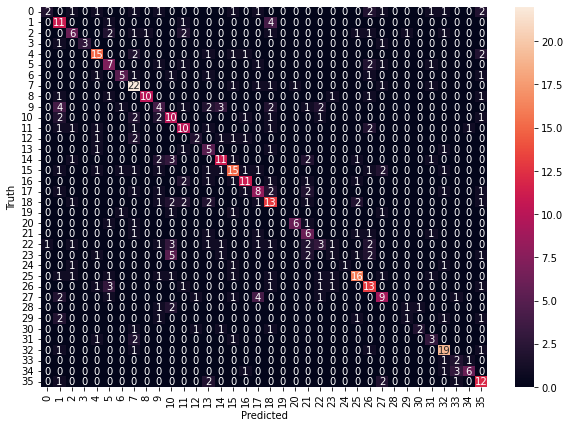

In [36]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [37]:
class_dict

{'Akshay Kumar': -1,
 'Alexandra Daddario': 0,
 'Alia Bhatt': 1,
 'Amitabh Bachchan': 2,
 'Andy Samberg': 3,
 'Anushka Sharma': 4,
 'Billie Eilish': 5,
 'Brad Pitt': 6,
 'Camila Cabello': 7,
 'Charlize Theron': 8,
 'Claire Holt': 9,
 'Courtney Cox': 10,
 'Dwayne Johnson': 11,
 'Elizabeth Olsen': 12,
 'Ellen Degeneres': 13,
 'Henry Cavill': 14,
 'Hrithik Roshan': 15,
 'Hugh Jackman': 16,
 'Jessica Alba': 17,
 'Kashyap': 18,
 'lionel_messi': 19,
 'Lisa Kudrow': 20,
 'Margot Robbie': 21,
 'maria_sharapova': 22,
 'Marmik': 23,
 'Natalie Portman': 24,
 'Priyanka Chopra': 25,
 'Robert Downey Jr': 26,
 'Roger Federer': 27,
 'roger_federer': 28,
 'serena_williams': 29,
 'Tom Cruise': 30,
 'Vijay Deverakonda': 31,
 'Virat Kohli': 32,
 'virat_kohli': 33,
 'Zac Efron': 34}

In [38]:
!pip install joblib
import joblib
joblib.dump(best_clf,'saved_model.pkl')

['saved_model.pkl']

In [39]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))